In [16]:
import shap
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute   import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold

from lightgbm import LGBMClassifier

plt.style.use('ggplot')

In [17]:
# Read data
raw_data = pd.read_excel('Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')
raw_data.sample(5)

# Data Preparation
raw_data['AGE_PERCENTIL'] = raw_data['AGE_PERCENTIL'].str.replace('Above ','').str.extract(r'(.+?)th')
raw_data['WINDOW'] = raw_data['WINDOW'].str.replace('ABOVE_12','12-more').str.extract(r'(.+?)-')

# Missingness as features
raw_data['row_missingness'] = raw_data.isnull().sum(axis=1)

# Mean imputation
mean_impute  = SimpleImputer(strategy='mean')
imputed_data = mean_impute.fit_transform(raw_data)
imputed_data = pd.DataFrame(imputed_data, columns = raw_data.columns)

In [18]:
list(imputed_data.columns)

['PATIENT_VISIT_IDENTIFIER',
 'AGE_ABOVE65',
 'AGE_PERCENTIL',
 'GENDER',
 'DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ALBUMIN_MEDIAN',
 'ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'ALBUMIN_DIFF',
 'BE_ARTERIAL_MEDIAN',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_ARTERIAL_DIFF',
 'BE_VENOUS_MEDIAN',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BE_VENOUS_DIFF',
 'BIC_ARTERIAL_MEDIAN',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_ARTERIAL_DIFF',
 'BIC_VENOUS_MEDIAN',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BIC_VENOUS_DIFF',
 'BILLIRUBIN_MEDIAN',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BILLIRUBIN_DIFF',
 'BLAST_MEDIAN',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'BLAST_DIFF',
 'CALCIUM_MEDIAN',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CALCIUM_

In [19]:
params = {'learning_rate': 0.05744913989406643,
 'n_estimators': 2067,
 'num_leaves': 8,
 'max_depth': 27,
 'max_bin': 384,
 'bagging_freq': 5,
 'bagging_fraction': 0.7038650070406707,
 'feature_fraction': 0.4806588217742334,
 'lambda_l1': 2.841137907985995,
 'lambda_l2': 5.983397074528167,
 'drop_rate': 0.490746746058113,
 'min_child_samples': 3,
 'min_child_weight': 0,
 'min_split_gain': 0.0,
 'scale_pos_weight': 0.91024410907254,
 'boosting_type': 'gbdt',
 'bagging_seed': 42,
 'metric': 'auc',
 'verbosity': -1,
 'random_state': 451,
 'max_drop': 50}

train_x, test_x = train_test_split(imputed_data.drop('PATIENT_VISIT_IDENTIFIER', axis=1),
                                   test_size = 0.3,
                                   stratify  = imputed_data['ICU'],
                                   random_state = 451
                                  )
        
train_y = train_x.pop('ICU')
test_y  = test_x.pop('ICU')


model = LGBMClassifier(**params)
model.fit(train_x, train_y)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4806588217742334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4806588217742334
[LightGBM] [Warning] bagging_fraction is set=0.7038650070406707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7038650070406707
[LightGBM] [Warning] lambda_l2 is set=5.983397074528167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.983397074528167
[LightGBM] [Warning] lambda_l1 is set=2.841137907985995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.841137907985995


LGBMClassifier(bagging_fraction=0.7038650070406707, bagging_freq=5,
               bagging_seed=42, drop_rate=0.490746746058113,
               feature_fraction=0.4806588217742334, lambda_l1=2.841137907985995,
               lambda_l2=5.983397074528167, learning_rate=0.05744913989406643,
               max_bin=384, max_depth=27, max_drop=50, metric='auc',
               min_child_samples=3, min_child_weight=0, n_estimators=2067,
               num_leaves=8, random_state=451,
               scale_pos_weight=0.91024410907254, verbosity=-1)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


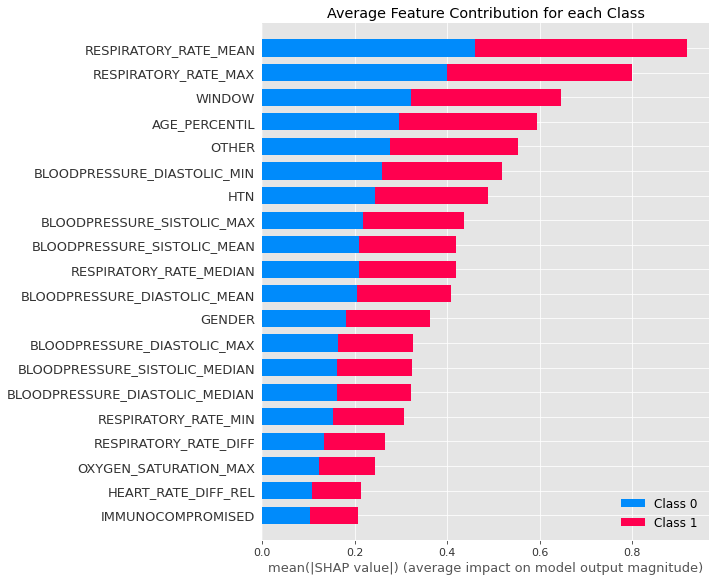

In [20]:
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)

# Feature Importance
plt.title('Average Feature Contribution for each Class')
shap.summary_plot(shap_values, train_x, plot_type="bar")

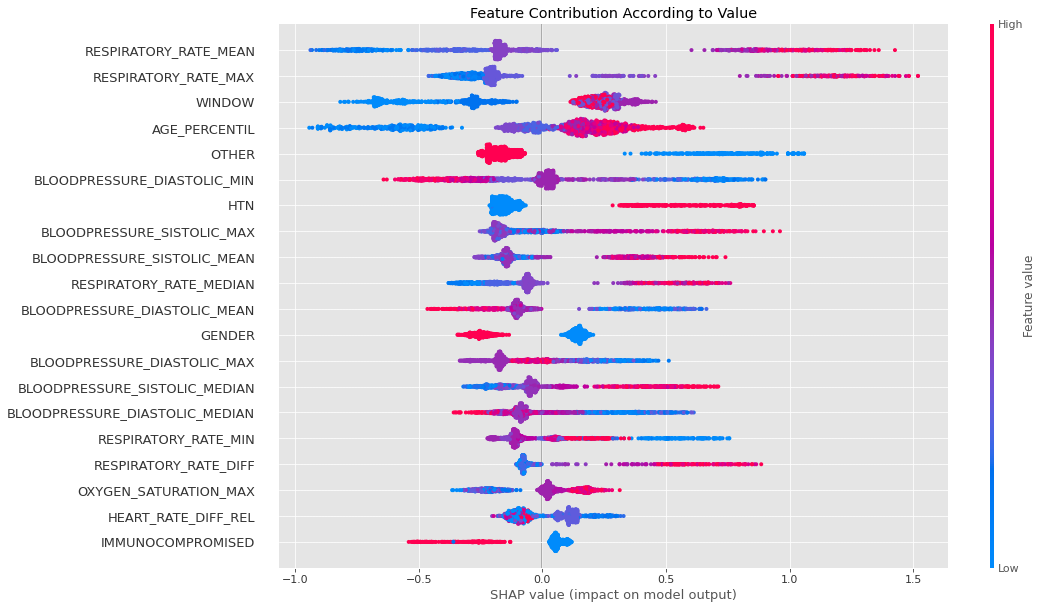

In [21]:
# Granular feature contribution plot
plt.title('Feature Contribution According to Value')
shap.summary_plot(shap_values[1], train_x, plot_size = (15,10))